In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings;
warnings.filterwarnings('ignore');

In [2]:
df=pd.read_csv("Train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [3]:
def remove_outliers(df, columns, multiplier=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

Original shape: (10999, 12)
Shape after removing outliers: (7971, 12)


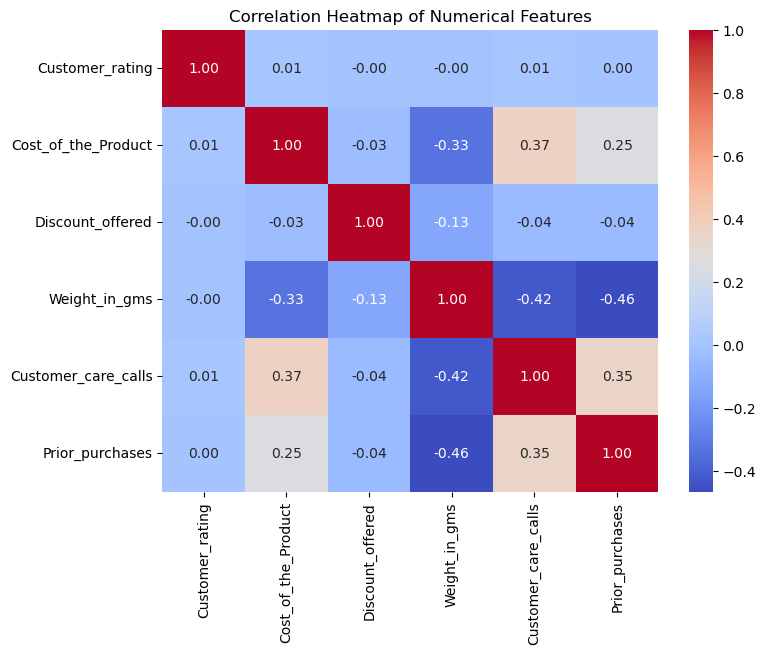

In [5]:
num_features = ['Customer_rating', 'Cost_of_the_Product', 'Discount_offered',
                'Weight_in_gms', 'Customer_care_calls', 'Prior_purchases']
df_no_outliers = remove_outliers(df, num_features)
print(f"Original shape: {df.shape}")
print(f"Shape after removing outliers: {df_no_outliers.shape}")
corr_matrix = df_no_outliers[num_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

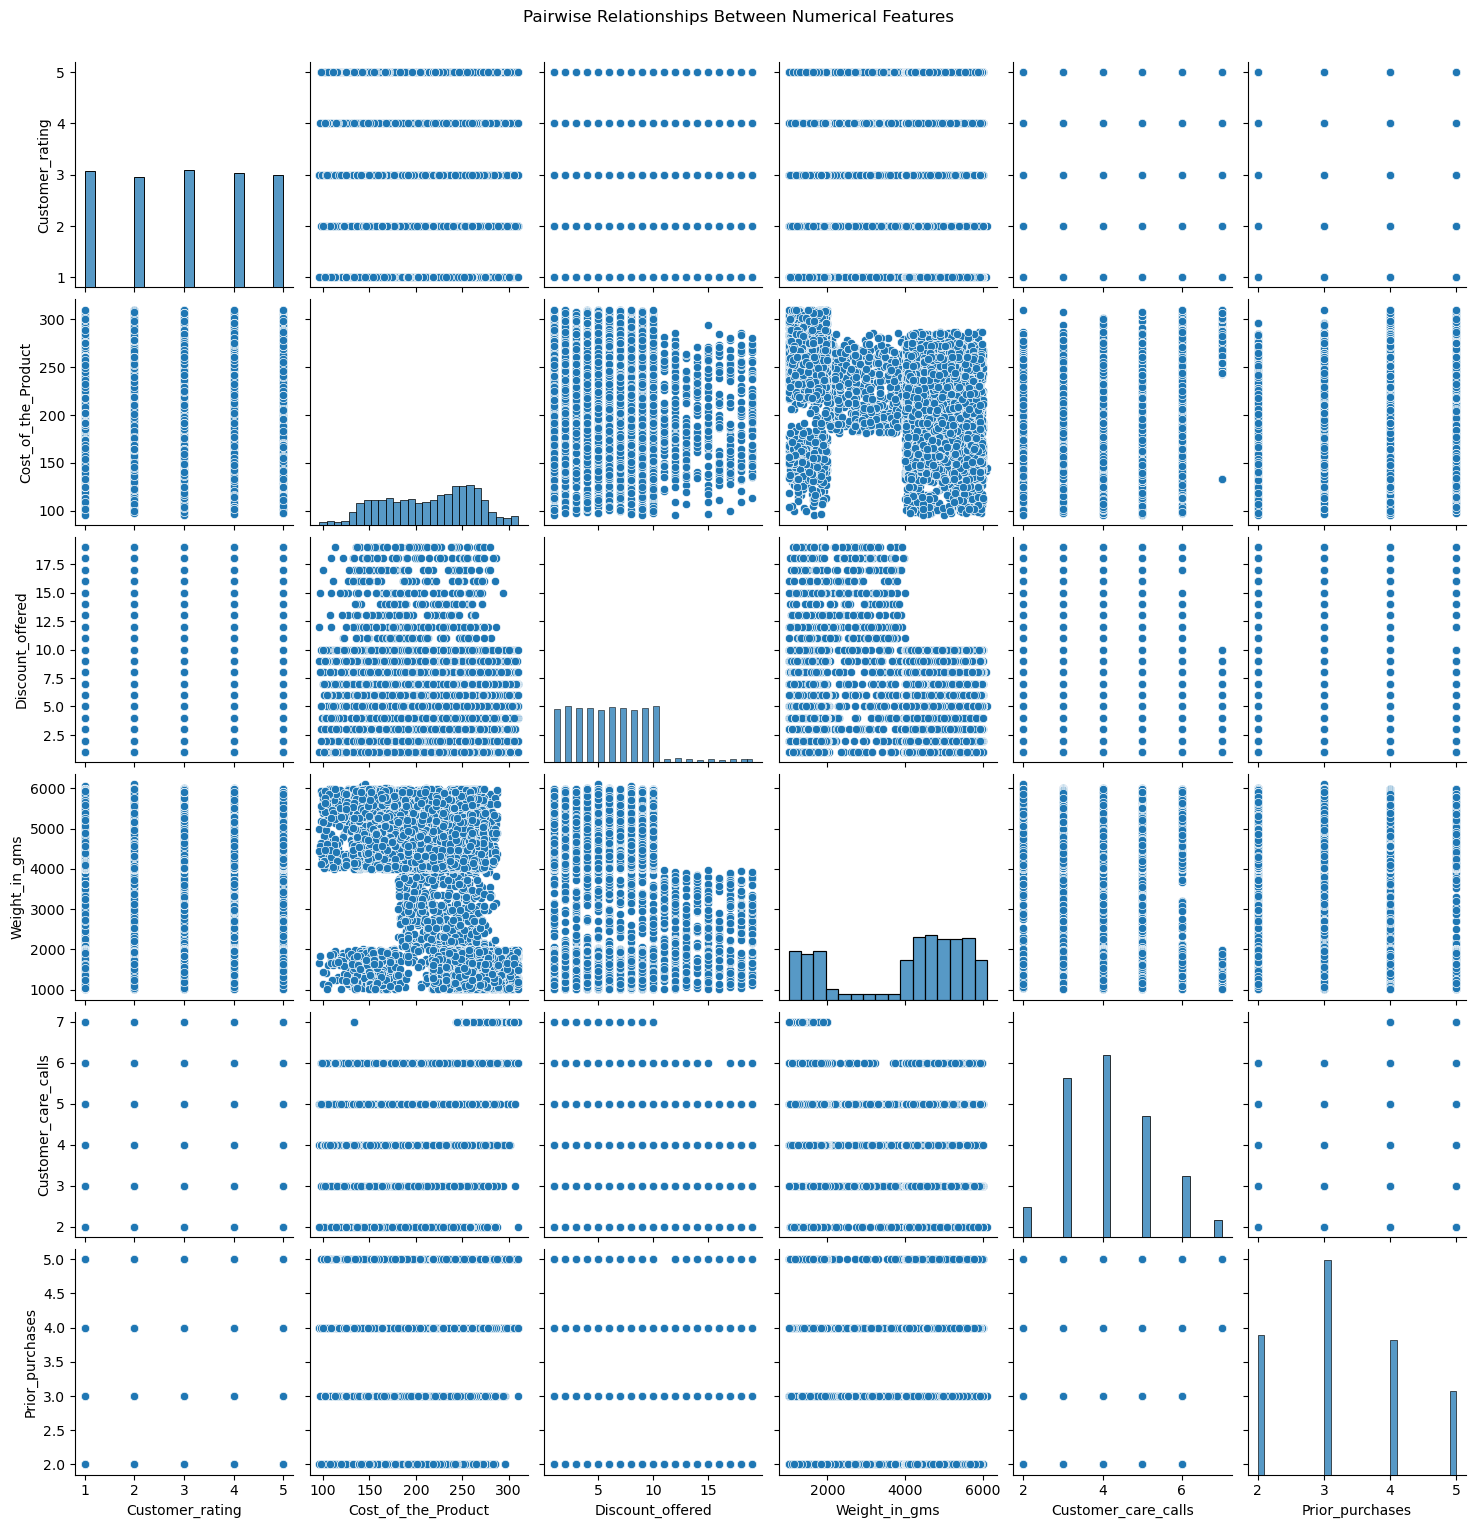

In [6]:
sns.pairplot(df_no_outliers[num_features])
plt.suptitle('Pairwise Relationships Between Numerical Features', y=1.02)
plt.show()

<Axes: xlabel='Warehouse_block', ylabel='Discount_offered'>

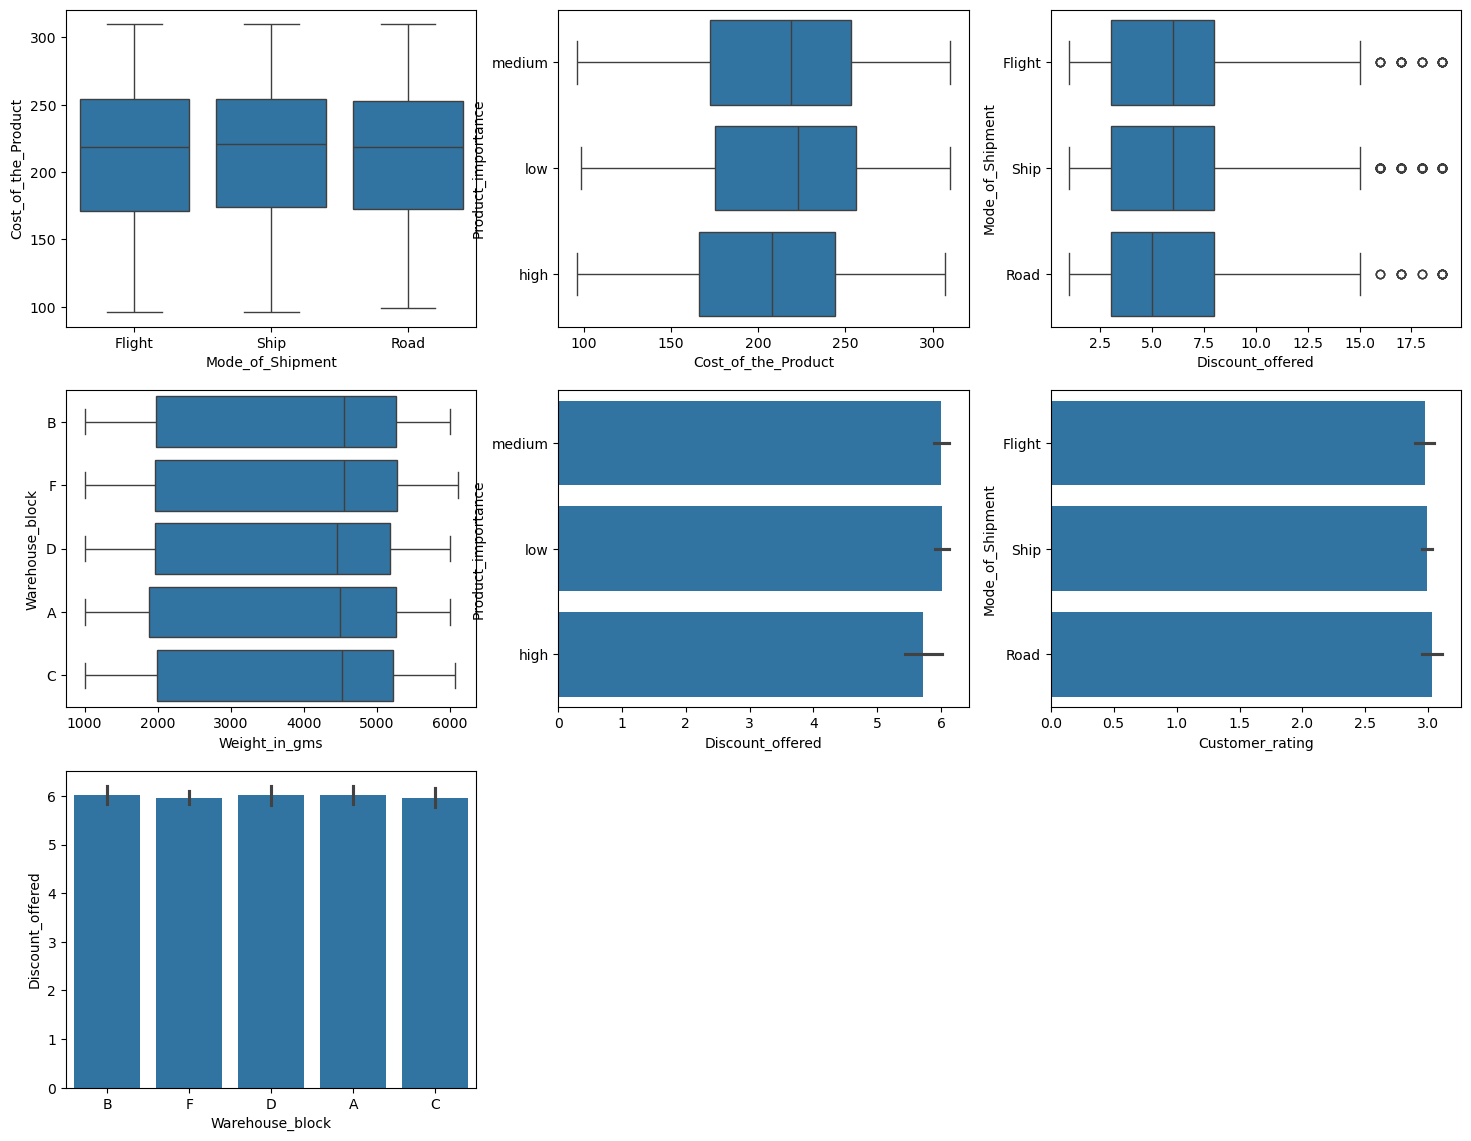

In [7]:
plt.figure(figsize=(18, 14))
plt.subplot(3,3,1)
sns.boxplot(x="Mode_of_Shipment",y="Cost_of_the_Product",data=df_no_outliers)
plt.subplot(3,3,2)
sns.boxplot(x="Cost_of_the_Product",y="Product_importance",data=df_no_outliers)
plt.subplot(3,3,3)
sns.boxplot(x="Discount_offered",y="Mode_of_Shipment",data=df_no_outliers)
plt.subplot(3,3,4)
sns.boxplot(x="Weight_in_gms",y="Warehouse_block",data=df_no_outliers)
plt.subplot(3,3,5)
sns.barplot(x="Discount_offered",y="Product_importance",data=df_no_outliers)
plt.subplot(3,3,6)
sns.barplot(x="Customer_rating",y="Mode_of_Shipment",data=df_no_outliers)
plt.subplot(3,3,7)
sns.barplot(x="Warehouse_block",y="Discount_offered",data=df_no_outliers)

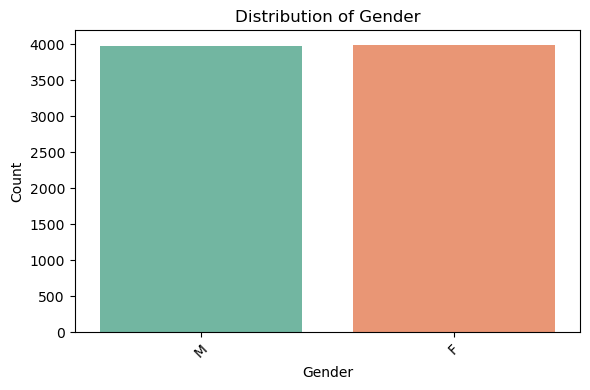

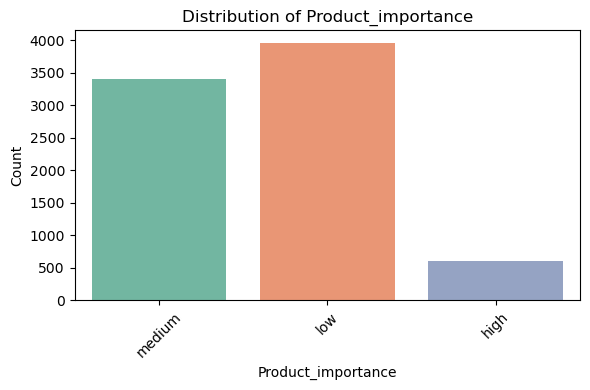

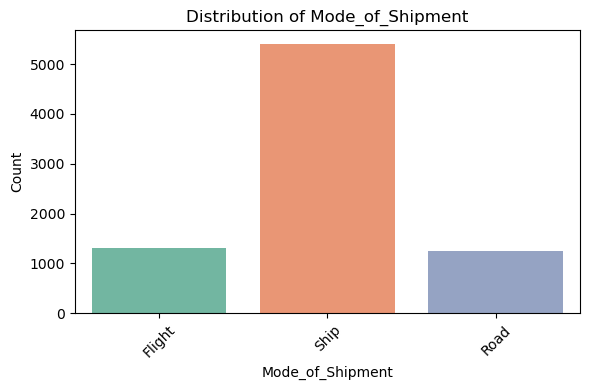

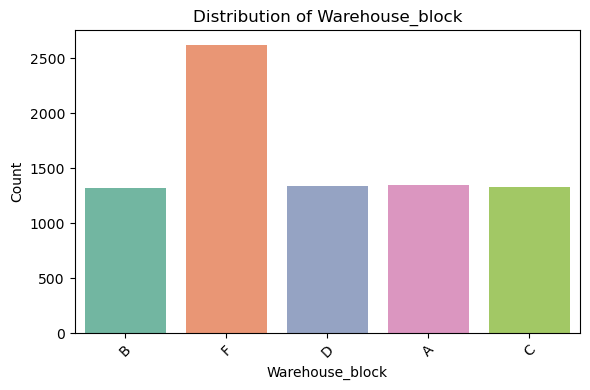

In [8]:
cat_features = ['Gender', 'Product_importance', 'Mode_of_Shipment', 'Warehouse_block']
for feature in cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_no_outliers, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
df.drop("ID", axis=1, inplace=True)
X = df_no_outliers.drop("Reached.on.Time_Y.N", axis=1)
Y = df_no_outliers["Reached.on.Time_Y.N"]

In [10]:
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

In [11]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [12]:
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve

model = LogisticRegression()
model.fit(X_train, Y_train)


LogisticRegression()

In [14]:
Y_pred = model.predict(X_test)
difference = pd.DataFrame(Y_test-Y_pred)
difference.value_counts()
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Precision: ", metrics.precision_score(Y_test,Y_pred))
print("Recall: ", metrics.recall_score(Y_test,Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))


Accuracy: 0.5655172413793104
Confusion Matrix:
 [[490 305]
 [388 412]]
Precision:  0.5746164574616457
Recall:  0.515
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59       795
           1       0.57      0.52      0.54       800

    accuracy                           0.57      1595
   macro avg       0.57      0.57      0.56      1595
weighted avg       0.57      0.57      0.56      1595



In [15]:
Y_pred_proba = model.predict_proba(X_test)[::,1]
print(Y_pred_proba)

[0.45764676 0.27009538 0.29050049 ... 0.68680069 0.56186811 0.55076494]


Text(0.5, 1.0, 'Confusion Matrix Heatmap')

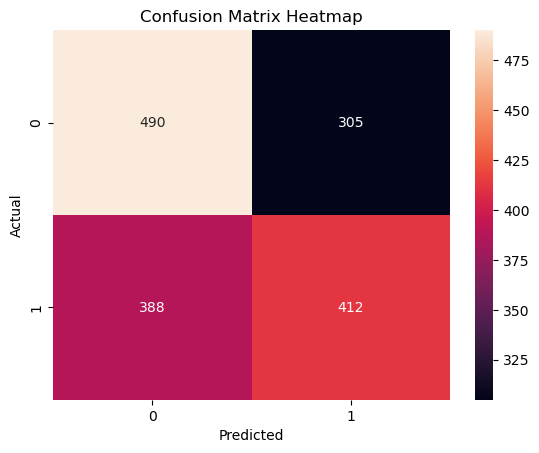

In [16]:
conf_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(conf_matrix,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')


0.6187405660377359


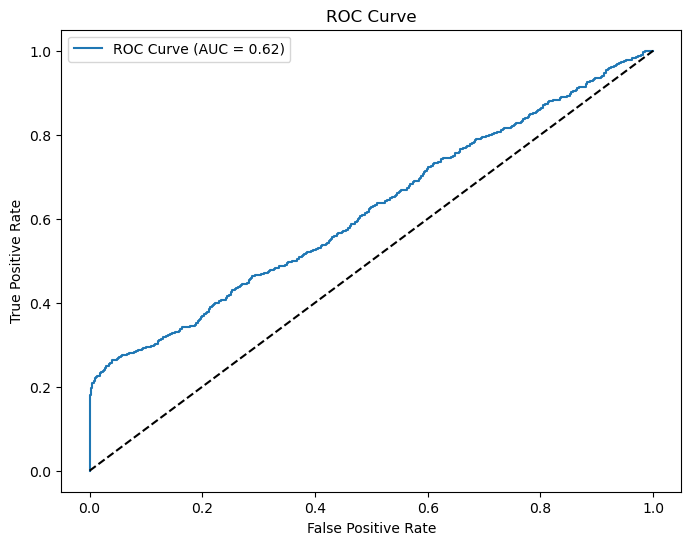

In [17]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_score = roc_auc_score(Y_test, Y_pred_proba)
print(roc_score)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

